In [1]:
import cv2
import numpy as np

Here, os module is used only to read subdirectory names

In [2]:
import os
root_path = '/Mystuff/2022 FALL/Computer Vision/Homeworks/Assignment 1/'
base_path =  root_path + '/dataset/train'
categories = os.listdir(base_path)
detector = cv2.ORB_create()
print(categories)

['brontosaurus', 'car_side', 'cougar_face', 'dalmatian', 'dollar_bill', 'dragonfly', 'Faces', 'Faces_easy', 'flamingo', 'headphone', 'lotus', 'menorah', 'nautilus', 'pagoda', 'soccer_ball', 'stop_sign', 'sunflower', 'tick', 'windsor_chair', 'yin_yang']


Initializing feature extractor

In [3]:
train_paths = []
train_labels = []
train_features = np.array([])
img_len = 30
count = 0

Extracting features for each train images, and concatenating them in one variable.

In [4]:
for idx, category in enumerate(categories):
  dir_path = base_path + '/' + category
  
  for i in range(img_len):
    img_path = dir_path + '/' + 'image_%04d.jpg' % (i+1)
    train_paths.append(img_path)
    train_labels.append(idx)
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    kpt, desc = detector.detectAndCompute(gray, None)
    if train_features.size == 0:
      train_features = np.float32(desc)
    else:
      train_features = np.append(train_features, np.float32(desc), axis=0)

    count+=1

Clustering extracted features into K visual words

In [5]:
def dict_init(train_features, dictionary_size, save_dictionary=False):
  criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.1) 
  ret, label, dictionary = cv2.kmeans(train_features, dictionary_size, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
  if save_dictionary:
    dict_file = root_path + '/dictionary.npy'
    np.save(dict_file, dictionary)
  return dictionary
dictionary = dict_init(train_features, 50, True)

Making image histograms

In [7]:
def knn_classifier(dictionary, dictionary_size, save_knn=False):
  knn = cv2.ml.KNearest_create()
  knn.train(dictionary, cv2.ml.ROW_SAMPLE, np.float32(range(dictionary_size)))
  if save_knn:
    knn_model_file = root_path + '/nearest_neighbor.xml'
    knn.save(knn_model_file)

  train_desc = np.float32(np.zeros((len(train_paths), dictionary_size)))

  for i, path in  enumerate(train_paths):
    img = cv2.imread(path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    kpt, desc = detector.detectAndCompute(gray, None)

    ret, result, neighbours, dist = knn.findNearest(np.float32(desc), k=1)
    hist, bins = np.histogram(np.int32(result), bins=range(dictionary_size + 1))
    train_desc[i, :] = np.float32(hist) / np.float32(np.sum(hist))
  return knn, train_desc
knn, train_desc = knn_classifier(dictionary, 50, True)

Training SVM classifier

In [8]:
def svm_classifier(train_desc, train_labels, save_svm=False):
  svm = cv2.ml.SVM_create()
  svm.trainAuto(train_desc, cv2.ml.ROW_SAMPLE, np.array(train_labels))
  if save_svm:
    svm_model_file = root_path + '/svmmodel.xml'
    svm.save(svm_model_file)
  return svm
svm = svm_classifier(train_desc, train_labels, True)

Here, we test our model

In [9]:
def test_stage(svm, knn, dictionary_size):
  test_desc = np.float32(np.zeros((100, dictionary_size)))
  test_path = root_path + '/dataset/test'
  img_len = 5
  test_labels = []
  for idx, category in enumerate(categories):
    dir_path = test_path + '/' + category
    for i in range(img_len):
      test_labels.append(idx)
      img_path = dir_path + '/' + 'image_%04d.jpg' % (i+31)
      img = cv2.imread(img_path)
      gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
      kpt, desc = detector.detectAndCompute(gray, None)
      ret, result, neighbours, dist = knn.findNearest(np.float32(desc), k=1)
      hist, bins = np.histogram(np.int32(result), bins=range(dictionary_size + 1))
      test_desc[idx*img_len + i, :] = np.float32(hist) / np.float32(np.sum(hist))
  _, result = svm.predict(test_desc)
  return result, test_desc, test_labels
result, test_desc, test_labels = test_stage(svm, knn, 50)

Here, we calculate error for our test data by using below formula $$\textrm{Accuracy} = \dfrac {\#\textrm{ of samples which are correctly predicted}} {\#\textrm{ of total samples}}$$

In [13]:
def accuracy(svm, test_desc, test_labels):
  test_data = cv2.ml.TrainData.create(test_desc, cv2.ml.ROW_SAMPLE, np.array(test_labels))
  res, _ = svm.calcError(test_data, True)
  return 100 - res
print(f"{accuracy(svm, test_desc, test_labels)}%")

40.0%


Finding relationship between number of codewords and accuracy

In [14]:
import time
dicsize_max = 100
dicsizes = []
acclist = []

for size in range(5, dicsize_max + 1, 5):
  dic = dict_init(train_features, size)
  knn1, train_desc = knn_classifier(dic, size)
  svm1 = svm_classifier(train_desc, train_labels)
  result, test_desc, test_labels = test_stage(svm1, knn1, size)
  dicsizes.append(size)
  acclist.append(accuracy(svm1, test_desc, test_labels))

Plotting the graph

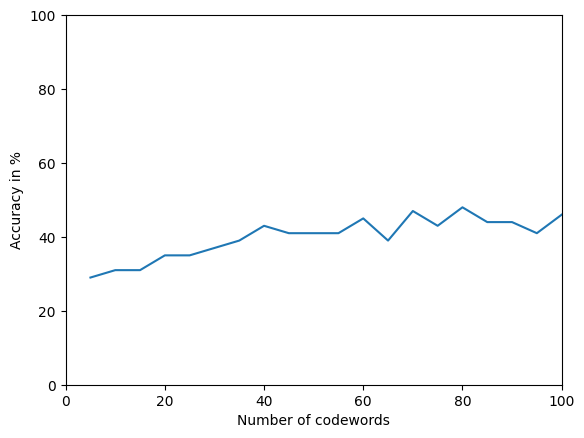

In [15]:
import matplotlib.pyplot as plt
plt.plot(dicsizes, acclist)
plt.xlabel("Number of codewords")
plt.ylabel("Accuracy in %")
plt.axis([0, 100, 0, 100])
plt.show()

Using "histogram intersection kernel" for "SVM" and measuring its accuracy

In [17]:
dic = dict_init(train_features, 50)
knn_inter, train_desc = knn_classifier(dic, 50)
svm_inter = svm_classifier(train_desc, train_labels)
svm_inter.setKernel(cv2.ml.SVM_INTER)
result, test_desc, test_labels = test_stage(svm_inter, knn_inter, 50)
print(f"{accuracy(svm_inter, test_desc, test_labels)}%")


24.0%


As you can see we have lower accuraccy with historgram intersection kernel